
<div align="center">
  <a href="https://www.w-hs.de/maschinenbau-master-boh/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png" 
    alt="Images" width="500" height="200">
  </a>
</div>
<br>
<h1 align="center"> Sondergebiete der Simulation</h1>
<h3 align="center"> WS 21/22 </h3>
<br>

<br>

### Credits:

* [benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

In [1]:
import sympy
from sympy import symbols, Function, diff, sin, cos, Matrix, Rational, Eq, solve, lambdify
import sympy.physics.mechanics as mech
mech.init_vprinting()

### Herleitung der Bewegungsgleichungen 

Ausführliche Beschreibung der Herleitung:
[Inverted Pendulum Legrange](https://github.com/lennart2810/InvertedPendulumSDS/blob/master/MKS/Inverted%20Pendulum%20Legrange.ipynb) 

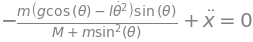

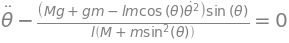

In [2]:
# symbolischen Variablen anlegen
t, l, M, m, g = symbols('t l M m g')

# Zwangsbedingung
y = 0

# generalisierte Koordinaten und deren Ableitungen:
x = Function('x')(t)
x_d = diff(x,t)
x_dd = diff(x_d,t)

theta = Function('theta')(t)
theta_d = diff(theta,t)
theta_dd = diff(theta,t,t)

# Kinematik
x2, y2 = x - l * sin(theta), y + l * cos(theta)
x2_d, y2_d = x2.diff(t), y2.diff(t)

# Legrange-Funktion
T = Rational(1,2) * M * (x_d)**2 + Rational(1,2) * m * (x2_d**2 + y2_d**2)
V = M * g * y + m * g * y2 
L = T - V

# Euler-Legrange
LE_x = diff(diff(L, x_d), t) - diff(L, x)
LE_theta = diff(diff(L, theta_d), t) - diff(L, theta)

# Nach x_dd und theta_dd umstellen
solutions = solve([LE_x, LE_theta], (x_dd, theta_dd), simplify=True) 
sol_x_dd = Eq(x_dd-solutions[x_dd], 0)
sol_theta_dd = Eq(theta_dd - solutions[theta_dd], 0)
display(sol_x_dd)
display(sol_theta_dd)
#display(Matrix([sol_x_dd, sol_theta_dd]))

### Umwandlung des symbolischen Gleichungssystems in numerische Funtkionen mit `sympy.lambdify`.

In [3]:
dxdt = lambdify(x_d, x_d)
dvdt = lambdify((t,g,M,m,l,theta,theta_d), solutions[x_dd])

dthetadt = lambdify(theta_d, theta_d)
domegadt = lambdify((t,g,M,m,l,theta,theta_d), solutions[theta_dd])

def dSdt(S, t, g, M, m, l):
    x, v, theta, omega = S
    return [
        dxdt(v),
        dvdt(t,g,M,m,l,theta, omega),
        dthetadt(omega),
        domegadt(t,g,M,m,l,theta,omega)
    ]

### Daten generieren

time.shape: (34,) <class 'numpy.ndarray'>
x.shape: (34,)
theta.shape: (34,)
data.shape: (34, 2)


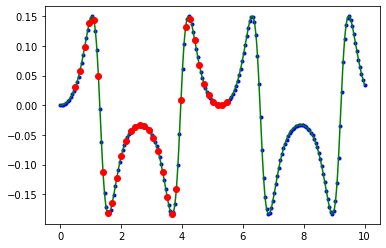

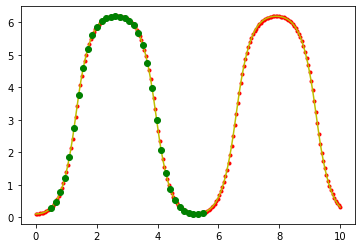

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interpolate

t1 = 10                          # s 
samples = 200                    # n 
t = np.linspace(0, t1, samples)     # s

g = 9.81                         # m/s^2
M = 5                            # kg
m = 1                            # kg
l = 1                            # m
F = 0                            # N

S0 = [0, 0, 0.1, 0]              # m, m/s, rad, rad/s

# numerische Lösung
ans = odeint(dSdt, y0=S0, t=t, args=(g, M, m, l))
x = ans.T[0]
theta = ans.T[2]

# numerische Lösung --> Lösungsfunktion interpolieren
# wird ausschließlich für DeepXDE benötigt (solution=func)
t_new = np.linspace(0, t1, samples+2000)    
x_f = interpolate.interp1d(t, x, 'cubic')
theta_f = interpolate.interp1d(t, theta, 'cubic')

# 'Messwerte'
a, b, i = 10, 110, 3 # jeden i. Punkt im Intervall [a,b] 
t_data = t[a:b:i]
x_data = x[a:b:i]
theta_data = theta[a:b:i]

# Data für NN zusammenfassen:
data = np.concatenate((x_data, theta_data)).reshape(2, len(t_data)).T
print('time.shape:', t_data.shape, type(t_data))
print('x.shape:', x_data.shape)
print('theta.shape:', theta_data.shape)
print('data.shape:', data.shape)


# Visualisierung 
plt.plot(t, x, 'b.')
plt.plot(t_new, x_f(t_new), 'g-')
plt.plot(t_data, data[:,0], 'ro') # data[:,1] --> x_data
plt.show()

plt.plot(t, theta, 'r.')
plt.plot(t_new, theta_f(t_new), 'y-')
plt.plot(t_data, data[:,1], 'go') # data[:,1] --> theta_data
plt.show()

### *Messpunkte* mit Tensorflow NN annähern

prediction.shape:  (200, 2)


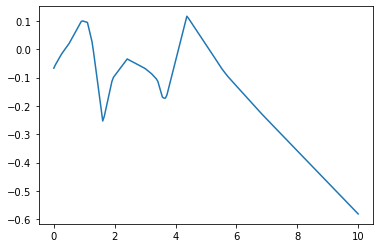

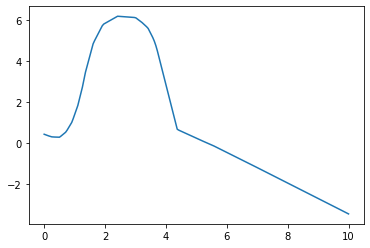

In [5]:
import tensorflow as tf
from tensorflow import keras

def my_mse(y_true, y_pred):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    return mse

def create_model_nn():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 2, activation = 'linear'))
    model.compile(loss=my_mse, optimizer="adam") # same as 'mse'
    return model


epochs = 20000
model = create_model_nn()
model.fit(t_data, data, epochs=epochs, verbose=0)
prediction = model.predict(t)
x_p = prediction[:,0]
theta_p = prediction[:,1]
print('prediction.shape: ', prediction.shape)
plt.plot(t, x_p)
plt.show()
plt.plot(t, theta_p)
plt.show()

### Animation des NN 
# Nicht ausführen!!!

duration: 360 [s]


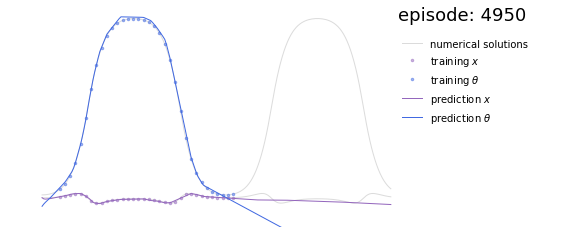

In [6]:
import time
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter

episodes = 5000
model = create_model_nn()

fig = plt.figure(figsize=(10,4))
ax = plt.axes(xlim=(-1, t1+5), ylim=(-1, 6.5), autoscale_on=False) 
ax.plot(t, x, color='lightgrey', marker='', lw=1, alpha=0.8, label='numerical solutions') # true x
ax.plot(t, theta, color='lightgrey', marker='', lw=1, alpha=0.8) # true theta
ax.plot(t_data, data[:,0], color="tab:purple", marker='.', lw=0, markersize=5, alpha=0.5, label='training $x$') 
ax.plot(t_data, data[:,1] , color="royalblue", marker='.', lw=0, markersize=5, alpha=0.5, label=r'training $\theta$')


line0, = ax.plot([], [], lw=1, color="tab:purple", label='prediction $x$') # predictio x 
line1, = ax.plot([], [], lw=1, color="royalblue", label=r'prediction $\theta$') # prediction theta
ax.axis("off")
ax.legend(loc=(0.7,0.45), frameon=False, fontsize=10)

episode_template = 'episode: %.0f'
episode_template_text = ax.text(0.7,0.95, '', fontsize=18, transform=ax.transAxes)

duration = 10 # Dauer der GIF Animation
n = 50 # jedes n. Frame in GIF aufnehemen

def animate(i):
    
    if i % n == 0:
        model.fit(t_data, data, epochs=n, verbose=0)
        prediction = model.predict(t)

        line0.set_data(t, prediction[:,0]) # x
        line1.set_data(t, prediction[:,1]) # theta
        episode_template_text.set_text(episode_template % (i))
        
    return line0, line1, episode_template_text

start = time.time()

#anim = animation.FuncAnimation(fig, animate, frames=episodes, blit=True)
#anim.save("InvertedPendulum_NN.gif", writer='pillow', fps=episodes/duration, dpi=200)

print('duration: %s [s]' % round(time.time() - start))

# $\rightarrow$ nicht besonders effizient !!!!
### Arbeitsspeicher Belastung steigt mit 12GB auf 95% 

# DeepXDE

### [A simple ODE system](https://deepxde.readthedocs.io/en/latest/demos/ode.system.html)

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.IC(geom, np.sin, boundary, component=0)
ic2 = dde.IC(geom, np.cos, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### [Poisson equation in 1D with Dirichlet boundary conditions](https://deepxde.readthedocs.io/en/latest/demos/poisson.1d.dirichlet.html)

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch

Documentation: https://deepxde.readthedocs.io/en/latest/demos/poisson.1d.dirichlet.html
"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Import torch if using backend pytorch
# import torch


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)
    # Use torch.sin for backend pytorch
    # return -dy_xx - np.pi ** 2 * torch.sin(np.pi * x)


def boundary(x, on_boundary):
    return on_boundary


def func(x):
    return np.sin(np.pi * x)


geom = dde.geometry.Interval(-1, 1)
bc = dde.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=10000)
# Optional: Save the model during training.
# checkpointer = dde.callbacks.ModelCheckpoint(
#     "model/model", verbose=1, save_better_only=True
# )
# Optional: Save the movie of the network solution during training.
# ImageMagick (https://imagemagick.org/) is required to generate the movie.
# movie = dde.callbacks.MovieDumper(
#     "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
# )
# losshistory, train_state = model.train(epochs=10000, callbacks=[checkpointer, movie])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()